## Lab 3-2: Object Localization

An object localization model is similar to a classification model. But the trained localization model also predicts where the object is located in the image by drawing a bounding box around it. For example, dogs is located in the image below. The information of the bounding box containing (xmin, ymin, xmax, ymax) is also included in the model output. We will use [The Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) throughout this lab.

![Alt Text](https://cdn-images-1.medium.com/max/1600/1*DuNdn6qIvGt-Wv65UwpQ_Q.jpeg)

In case that your google drive is unmounted, please add this zip file to your google drive (by clicking google drive symbol on the top-right) and change the unzip path accordingly: https://drive.google.com/open?id=1UCRGAy6hin1Uhsscn150zVvGgKiaePmJ. 

Then mount it to the local machine this notebook is running on by the following command:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!unzip '/content/gdrive/My Drive/lab3-nvidia-chula.zip'

Archive:  /content/gdrive/My Drive/lab3-nvidia-chula.zip
warning [/content/gdrive/My Drive/lab3-nvidia-chula.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
replace dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/.DS_Store       
  inflating: dataset/lab3-1/10_flower/validate/class_4/image_0290.jpg  
  inflating: dataset/lab3-1/10_flower/validate/class_4/image_0291.jpg  
  inflating: dataset/lab3-1/10_flower/validate/class_4/image_0293.jpg  
  inflating: dataset/lab3-1/10_flower/validate/class_4/image_0292.jpg  
  inflating: dataset/lab3-1/10_flower/validate/class_4/image_0296.jpg  
  inflating: dataset/lab3-1/10_flower/validate/class_4/image_0297.jpg  
  inflating: dataset/lab3-1/10_flower/validate/class_4/image_0295.jpg  
  inflating: dataset/lab3-1/10_flower/validate/class_4/image_0294.jpg  
  inflating: dataset/la

## Import used python libraries

In [3]:
%matplotlib inline
import matplotlib.patches as patches
import matplotlib.pyplot as plt
 
# import the necessary packages
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras import optimizers 
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import numpy as np
np.random.seed(12)
from numpy.random import seed
seed(12)
from tensorflow import set_random_seed
set_random_seed(12)

import random
from xml.dom import minidom
from tqdm import tqdm, tqdm_notebook
import glob
import math
import cv2
import warnings


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


## Data preprocessing

Read training, validation and testing dataset
- Data augmentation strategies using ImageDataGenerator
- Substract RBG dataset by mean which is the preprocessing of VGG19
- labels contain `(min_x, min_y, max_x, max_y)` scaling from actual image sizes to `IMAGE_SIZE` variable

In [0]:
# glob.glob('dataset/lab3-2/annotations/xmls/*.xml')

In [5]:
# initialize the data and labels
# print("[INFO] loading images...")
IMAGE_SIZE = 224
data = []
labels = []
boxes = []

xml_files = glob.glob('./dataset/lab3-2/annotations/xmls/*.xml')
random.shuffle(xml_files)

# loop over the input images
for xml_file in tqdm(xml_files[:50]):
    doc = minidom.parse(xml_file)
    
    img_file = doc.getElementsByTagName("filename")[0].firstChild.nodeValue
    raw_image = './dataset/lab3-2/images/{}'.format(img_file)
    inputShape = (224,224)
    image = load_img(raw_image, target_size=inputShape)
    image = img_to_array(image)   # shape is (224,224,3)
    image = preprocess_input(image)
    
    data.append(image)
    
    height = int(doc.getElementsByTagName("height")[0].firstChild.nodeValue)
    width = int(doc.getElementsByTagName("width")[0].firstChild.nodeValue)
    xmin = int(doc.getElementsByTagName("xmin")[0].firstChild.nodeValue)
    xmax = int(doc.getElementsByTagName("xmax")[0].firstChild.nodeValue)
    ymin = int(doc.getElementsByTagName("ymin")[0].firstChild.nodeValue)
    ymax = int(doc.getElementsByTagName("ymax")[0].firstChild.nodeValue)

    labels.append([(xmin/width)*IMAGE_SIZE, (ymin/height)*IMAGE_SIZE, (xmax/width)*IMAGE_SIZE, (ymax/height)*IMAGE_SIZE])
    
    time.sleep(0.1)
    
# print("[INFO] finish loading images...")

100%|██████████| 50/50 [00:05<00:00,  8.99it/s]


In [0]:
data = np.array(data)

In [0]:
labels = np.array(labels)

In [0]:
data_size = len(data)

In [9]:
print(data.shape, labels.shape)

(50, 224, 224, 3) (50, 4)


In [10]:
# split training, validatation, testing dataset
print("[INFO] spliting train, val, test...")

train_X = data[:math.ceil(0.6*data_size)]
train_Y = labels[:math.ceil(0.6*data_size)]

val_X = data[math.ceil(0.6*data_size):math.ceil(0.8*data_size)]
val_Y = labels[math.ceil(0.6*data_size):math.ceil(0.8*data_size)]

test_X = data[math.ceil(0.8*data_size):]
test_Y = labels[math.ceil(0.8*data_size):]
# test_boxes = boxes[math.ceil(0.8*data_size):]

[INFO] spliting train, val, test...


In [11]:
train_X.shape, val_X.shape, test_X.shape

((30, 224, 224, 3), (10, 224, 224, 3), (10, 224, 224, 3))

In [12]:
train_Y.shape, val_Y.shape, test_Y.shape

((30, 4), (10, 4), (10, 4))

In [0]:
# construct the image generator for data augmentation
batch_size = 8

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
 
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_X, train_Y, batch_size=batch_size)
 
validation_generator = validation_datagen.flow(val_X, val_Y, batch_size=batch_size)

In [0]:
curr_dir = os.path.dirname('__file__')

## Modeling

Define `VGG19` Base model (pre-trained model) 

With pre-trained model, `VGG19` in this case, we can use it as the feature extractor. This means that you would be able do different tasks by changing the output layer.

In the experiment, we would perform regression task by changing output layer to be linear activation instead of softmax activation and ,similar to the previous experiment, the checkpoint and early stopping callbacks are used.

#### Comparing bounding box prediction accuracy can be done by Intersection Over Union (IoU), so that we use IoU to be model's loss and metric
measures the overlap between the predicted and the real bounding box. It’s calculated by dividing the area of intersection (red in the image below) by the area of union (blue). The IOU is between 0 (no overlap) and 1 (perfect overlap).

![Alt Text](https://cdn-images-1.medium.com/max/1600/0*yfiUxmf84sXuyqwt.)

In [0]:
# from keras import backend as K

# def mean_absolute_error(y_true, y_pred):
#     return K.mean(K.abs(y_pred - y_true), axis=-1)

## Model 1
- VGG19 (pre-trained weights) + Output layer

In [16]:
base_model = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.get_layer('fc2').output
outputs = Dense(4, activation='relu')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', mode='min', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=4, min_lr=0)
early_stopper = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, 
                           patience=20, verbose=0, mode='min')

model_1_path = os.path.abspath(os.path.join(curr_dir, "./model/lab3_2/model_1.h5"))
checkpoint = ModelCheckpoint(model_1_path, monitor='val_mean_absolute_error', verbose=1,save_best_only=True,save_weights_only=False, mode='min',period=1)
callbacks_list = [checkpoint, early_stopper, reduce_lr]

# Create and compile model
model_1 = Model(inputs=base_model.input, outputs=outputs)
model_1.compile(loss='mae', optimizer=optimizers.Adam(lr=0.0001), metrics=['mae'])

pretrained_model_1_path = os.path.abspath(os.path.join(curr_dir, "./model/const_models/lab3_2/model_1.h5"))
model_1.load_weights(pretrained_model_1_path)

## Run until early stopping
num_training_img=30
num_validation_img=10
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size
model_1.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=5,
        callbacks=callbacks_list,
        validation_data=validation_generator,
        validation_steps=validationSteps
        )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
4/3 [================================] - 7s 2s/step - loss: 22.6525 - mean_absolute_error: 22.6525 - val_loss: 24.2231 - val_mean_absolute_error: 24.2231

Epoch 00001: val_mean_absolute_error improved from inf to 24.22308, saving model to /content/model/lab3_2/model_1.h5
Epoch 2/5
4/3 [================================] - 1s 222ms/step - loss: 22.8002 - mean_absolute_error: 22.8002 - val_loss: 24.2483 - val_mean_absolute_error: 24.2483

Epoch 00002: val_mean_absolute_error did not improve from 24.22308
Epoch 3/5
4/3 [================================] - 1s 192ms/step - loss: 22.2071 - mean_absolute_error: 22.2071 - val_loss: 24.2757 - val_mean_absolute_error: 24.2757

Epoch 00003: val_mean_absolute_error did not improve from 24.22308
Epoch 4/5
4/3 [================================] - 1s 190ms/step - loss: 21.5739 - mean_absolute_error: 21.5739 - val_loss: 24.3

## Model 2
- VGG19 (pre-trained weights) + Output layer with fine-tuning

In [17]:
base_model = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Unfreeze pretrained only dense layer
for layer in base_model.layers:
    layer.trainable = False

base_model.get_layer('fc1').trainable = True
base_model.get_layer('fc2').trainable = True

x = base_model.get_layer('fc2').output
outputs = Dense(4, activation='relu')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', mode='min', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=4, min_lr=0)
early_stopper = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, 
                           patience=20, verbose=0, mode='min')

model_2_path = os.path.abspath(os.path.join(curr_dir, "./model/lab3_2/model_2.h5"))
checkpoint = ModelCheckpoint(model_2_path, monitor='val_mean_absolute_error', verbose=1,save_best_only=True,save_weights_only=False, mode='min',period=1)
callbacks_list = [checkpoint, early_stopper, reduce_lr]

# Create and compile model
model_2 = Model(inputs=base_model.input, outputs=outputs)
model_2.compile(loss='mae', optimizer=optimizers.Adam(lr=0.000001), metrics=['mae'])

pretrained_model_2_path = os.path.abspath(os.path.join(curr_dir, "./model/const_models/lab3_2/model_2.h5"))
model_2.load_weights(pretrained_model_2_path)

## Run until early stopping
num_training_img=30
num_validation_img=10
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size
model_2.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=5,
        callbacks=callbacks_list,
        validation_data=validation_generator,
        validation_steps=validationSteps
        )

Epoch 1/5
4/3 [================================] - 5s 1s/step - loss: 10.0852 - mean_absolute_error: 10.0852 - val_loss: 11.4185 - val_mean_absolute_error: 11.4185

Epoch 00001: val_mean_absolute_error improved from inf to 11.41848, saving model to /content/model/lab3_2/model_2.h5
Epoch 2/5
4/3 [================================] - 1s 326ms/step - loss: 10.1507 - mean_absolute_error: 10.1507 - val_loss: 7.7639 - val_mean_absolute_error: 7.7639

Epoch 00002: val_mean_absolute_error improved from 11.41848 to 7.76386, saving model to /content/model/lab3_2/model_2.h5
Epoch 3/5
4/3 [================================] - 1s 313ms/step - loss: 9.0202 - mean_absolute_error: 9.0202 - val_loss: 7.9079 - val_mean_absolute_error: 7.9079

Epoch 00003: val_mean_absolute_error did not improve from 7.76386
Epoch 4/5
4/3 [================================] - 1s 318ms/step - loss: 8.5709 - mean_absolute_error: 8.5709 - val_loss: 9.8125 - val_mean_absolute_error: 9.8125

Epoch 00004: val_mean_absolute_error 

## Evaluation

In [0]:
model_1_path = os.path.abspath(os.path.join(curr_dir, "./model/lab3_2/model_1.h5"))
model_2_path = os.path.abspath(os.path.join(curr_dir, "./model/lab3_2/model_2.h5"))

model_1.load_weights(model_1_path)
model_2.load_weights(model_2_path)

In [0]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    if bb1['x1'] > bb1['x2'] or bb1['y1'] > bb1['y2'] or bb2['x1'] > bb2['x2'] or bb2['y1'] > bb2['y2']:
        return 0.0

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [20]:
idx_to_model = {
    1: model_1,
    2: model_2,
}
idx_to_ious = {
    1: [],
    2: [],
}

for idx in tqdm(range(len(test_X))):
    for model_idx in range(1, 3):
        model = idx_to_model[model_idx]
        x = np.expand_dims(test_X[idx], axis=0) # Now shape is (1,224,224,3)
        
        (xmin, ymin, xmax, ymax) = model.predict(x)[0]
        pred_box = {
            'x1': xmin, 
            'y1': ymin, 
            'x2': xmax, 
            'y2': ymax
        }
         
        (xmin, ymin, xmax, ymax) = test_Y[idx]
        true_box = {
            'x1': xmin, 
            'y1': ymin, 
            'x2': xmax, 
            'y2': ymax
        }
        
        _iou = get_iou(true_box, pred_box)
        idx_to_ious[model_idx].append(_iou)

100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


In [21]:
print("IoU for each models.")
for model_idx in range(1, 3):
    print("-- Model_{}: iou_mean:{:.4f}, iou_std:{:.4f}".format(model_idx, 
                                                                np.mean(idx_to_ious[model_idx]), 
                                                                np.std(idx_to_ious[model_idx])))

IoU for each models.
-- Model_1: iou_mean:0.3671, iou_std:0.2148
-- Model_2: iou_mean:0.5082, iou_std:0.2612


## Result
There are 2 boxes to be plotted, box from ground truth (green color) and box from predictions (red color), using `Rectangle patches` from matplotlib. 


Result examples:


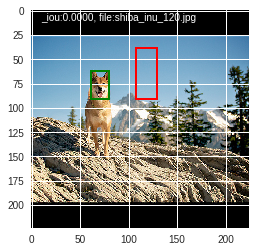

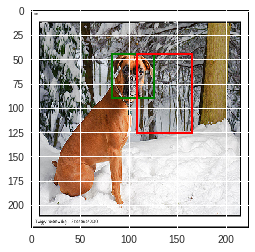

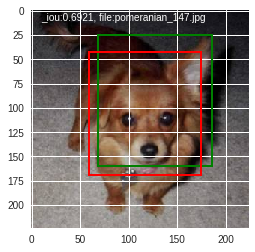

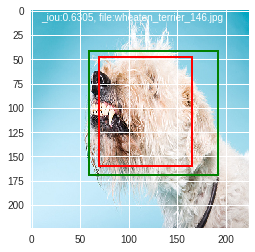

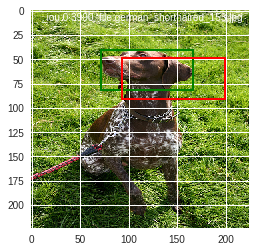

In [22]:
print("\nResult examples:")
for xml_file in xml_files[5:10]:
    doc = minidom.parse(xml_file)

    img_file = doc.getElementsByTagName("filename")[0].firstChild.nodeValue
    raw_image = './dataset/lab3-2/images/{}'.format(img_file)
    inputShape = (224,224)
    image = load_img(raw_image, target_size=inputShape)
    image = img_to_array(image)   # shape is (224,224,3)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)

    height = int(doc.getElementsByTagName("height")[0].firstChild.nodeValue)
    width = int(doc.getElementsByTagName("width")[0].firstChild.nodeValue)
    xmin = int(doc.getElementsByTagName("xmin")[0].firstChild.nodeValue)
    xmax = int(doc.getElementsByTagName("xmax")[0].firstChild.nodeValue)
    ymin = int(doc.getElementsByTagName("ymin")[0].firstChild.nodeValue)
    ymax = int(doc.getElementsByTagName("ymax")[0].firstChild.nodeValue)

    scale_xmin = (xmin/width)*IMAGE_SIZE
    scale_ymin = (ymin/height)*IMAGE_SIZE
    scale_xmax = (xmax/width)*IMAGE_SIZE
    scale_ymax = (ymax/height)*IMAGE_SIZE
    scale_width = scale_xmax-scale_xmin
    scale_height = scale_ymax-scale_ymin
    true_box = {
        'x1': scale_xmin, 
        'y1': scale_ymin, 
        'x2': scale_xmax, 
        'y2': scale_ymax
    }

    (xmin, ymin, xmax, ymax) = model_2.predict(np.array(image))[0]
    width = xmax-xmin
    height = ymax-ymin
    pred_box = {
        'x1': xmin, 
        'y1': ymin, 
        'x2': xmax, 
        'y2': ymax
    }

    _iou = get_iou(true_box, pred_box)
    
    im = np.array(load_img(raw_image, target_size=(224, 224)))

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch
    true_rect = patches.Rectangle((scale_xmin,scale_ymin),scale_width,scale_height,linewidth=2,edgecolor='g',facecolor='none')
    pred_rect = patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(true_rect)
    ax.add_patch(pred_rect)

    plt.text(10, 10,"_iou:{:.4f}, file:{}".format(_iou, img_file), fontdict={'color': 'white'})

    plt.show()